<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_projecoes_de_notificacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Projeções (time series) de notificações

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Conv1D, Dense, Input, GRU, Lambda, Layer, LSTM, SimpleRNN, Subtract
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from absl import logging as absl_logging

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']     = 100

# plt.style.use('seaborn-darkgrid')
# plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("darkgrid")

SEMENTE = 2001088 + 2001247 + 2003061 + 2005493 + 2008193 + 2008620 + 2008880

# JANELA_TAMANHO_INICIAL = 5
# JANELA_TAMANHO_FINAL   = 7  # Não incluído

JANELA_TAMANHO    = 6
HORIZONTE_TAMANHO = 1

CAMINHO_MARCOS = 'marcos'

# https://www.tensorflow.org/api_docs/python/tf/get_logger
tf.get_logger().setLevel('ERROR')

# https://abseil.io/docs/python/guides/logging
absl_logging.set_verbosity(absl_logging.ERROR)

## Hiperparâmetros

In [3]:
LOTE_TAMANHO = 32

CAMADAS = 4

CAMADA_UNIDADES      = 64
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

PROFUNDO_POTENCIA_INICIAL = 5
PROFUNDO_POTENCIA_FINAL   = 10  # Não incluída
PROFUNDO_REPETICAO        = 2
PROFUNDO_CONSOLIDACAO     = 32

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'linear'

PERDA       = 'mae'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
# METRICAS    = ['mae', 'mse']

ITERACOES = 500

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py

--2023-05-18 18:14:16--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7584 (7.4K) [text/plain]
Saving to: ‘PJI410_funcoes_auxiliares.py’

PJI410_funcoes_auxi 100%[===================>]   7.41K  --.-KB/s    in 0s      

2023-05-18 18:14:16 (103 MB/s) - ‘PJI410_funcoes_auxiliares.py’ saved [7584/7584]



In [5]:
from PJI410_funcoes_auxiliares import criar_janelas, criar_marco_modelo, grafico_historico_por_iteracao, grafico_series, \
                                      metricas_modelo, separar_janelas_treino_teste, set_global_determinism

In [6]:
def finalizar_modelo(modelo, modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste):

    modelo.compile(loss=PERDA, optimizer=OTIMIZADOR(learning_rate=APRENDIZADO)) #, metrics=METRICAS)

    historico = modelo.fit(x=janelas_treino,
                           y=horizontes_treino,
                           epochs=ITERACOES,
                           batch_size=LOTE_TAMANHO,
                           validation_data=(janelas_teste, horizontes_teste),
                           callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=50, factor=0.3, verbose=0),
                                      criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                           verbose=0)

    modelo    = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
    previsoes = modelo.predict(janelas_teste, verbose=0)
    metricas  = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

    return historico, modelo, previsoes, metricas

# Dados

In [7]:
dados = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_notificacoes_por_municipio.csv', parse_dates=['Segunda-feira'])
dados = dados[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).sum().sort_index().reset_index()

quantidades = dados['Quantidade'].to_numpy().astype('float32')

q_treino = int(len(dados) * 0.8)

# X_train = dados[:q_treino]['Segunda-feira'].to_numpy()
# y_train = dados[:q_treino]['Quantidade'].to_numpy()

X_test = dados[q_treino:]['Segunda-feira'].to_numpy()
y_test = dados[q_treino:]['Quantidade'].to_numpy()

# len(quantidades), len(X_train), len(y_train), len(X_test), len(y_test)

# Modelos

In [8]:
modelos  = [None] * 50
metricas = [None] * 50

MODELO_NUMERO = 0

## Modelo Ingênuo

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

{'Mean Absolute Error': 641.4347826086956, 'Root Mean Squared Error': 844.8827291920202, 'Mean Absolute Percentage Error': 0.10835894926319017}



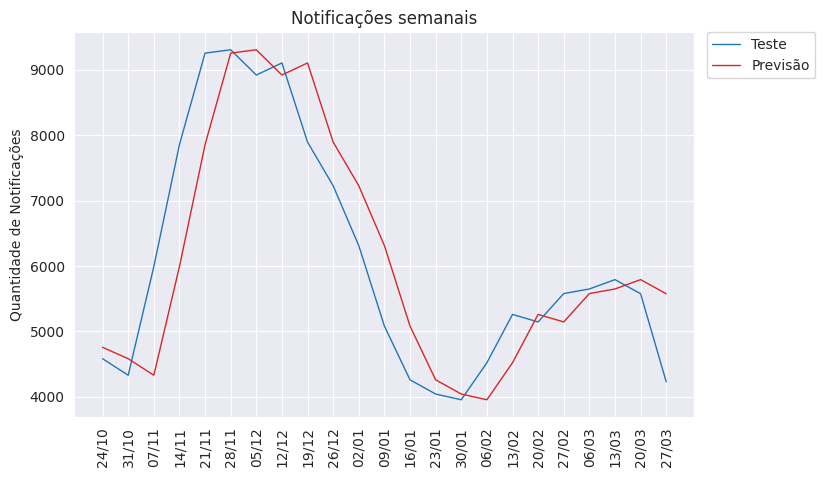

In [9]:
y_pred = y_test[:-1]

metricas[MODELO_NUMERO] = metricas_modelo(y_test[1:], y_pred)

print(metricas[MODELO_NUMERO])
print()

MODELO_NUMERO += 1

grafico_series(X_teste=X_test[1:], y_teste=y_test[1:],
               X_previsao=X_test[1:], y_previsao=y_pred)

## Modelos Densos

modelo_1_denso_6j_1h
{'Mean Absolute Error': 590.8514, 'Root Mean Squared Error': 803.38275, 'Mean Absolute Percentage Error': 0.09767643}



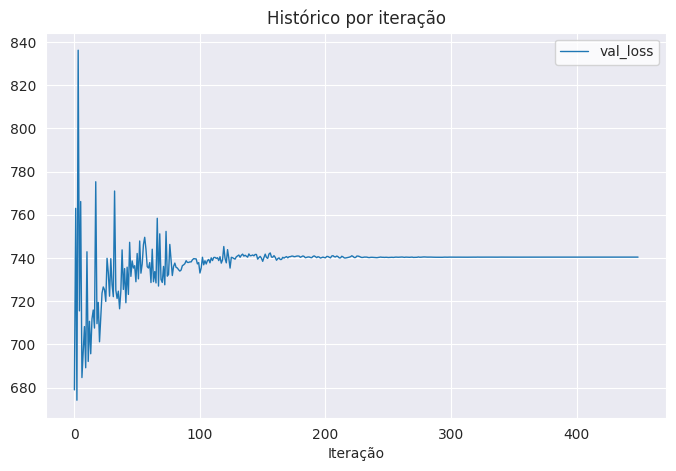

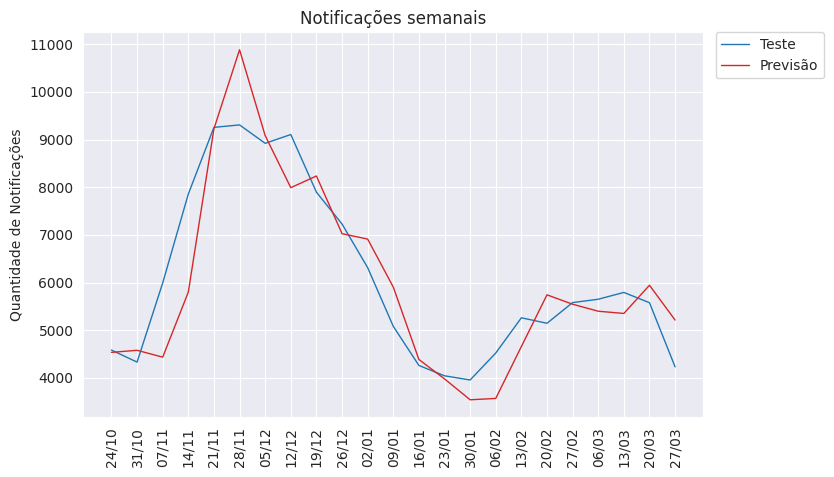


CPU times: user 37.3 s, sys: 2.41 s, total: 39.7 s
Wall time: 47.1 s


In [10]:
%%time

set_global_determinism(seed=SEMENTE)

# for JANELA_TAMANHO in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

janelas, horizontes = criar_janelas(quantidades, JANELA_TAMANHO, HORIZONTE_TAMANHO)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

modelo_nome = f'modelo_{MODELO_NUMERO}_denso_{JANELA_TAMANHO}j_{HORIZONTE_TAMANHO}h'

modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

for c in range(CAMADAS):
    modelos[MODELO_NUMERO].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}'))

modelos[MODELO_NUMERO].add(Dense(units=HORIZONTE_TAMANHO, activation=SAIDA_ATIVACAO, name='camada_saida'))

finalizacoes = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

historico               = finalizacoes[0]
modelos[MODELO_NUMERO]  = finalizacoes[1]
previsoes               = finalizacoes[2]
metricas[MODELO_NUMERO] = finalizacoes[3]

print(modelo_nome)
print(metricas[MODELO_NUMERO])
print()

grafico_historico_por_iteracao(historico, ['val_loss'], 50)
print()

grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])
print()

MODELO_NUMERO += 1

## Modelos Densos Profundos

modelo_2_denso_profundo_6j_1h
{'Mean Absolute Error': 592.0693, 'Root Mean Squared Error': 780.5143, 'Mean Absolute Percentage Error': 0.10252062}



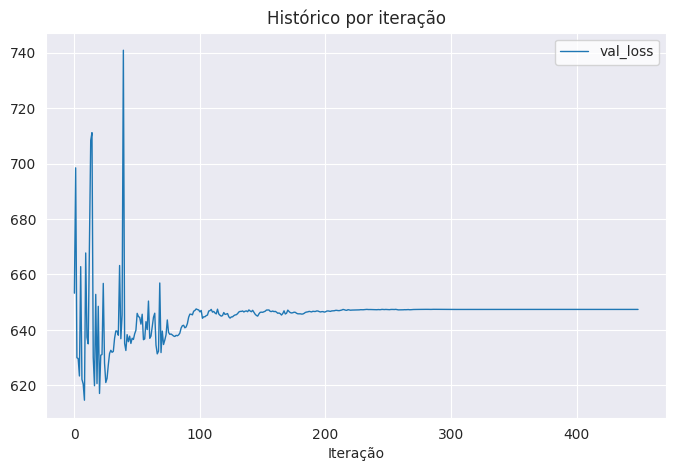

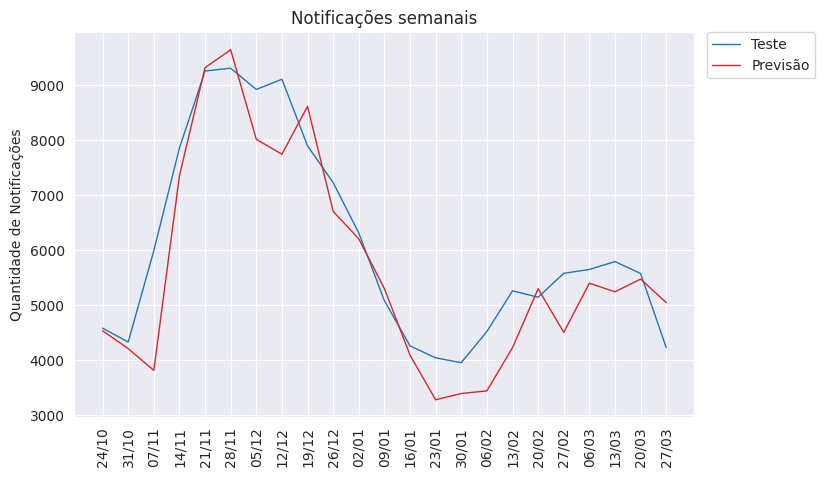


CPU times: user 40.5 s, sys: 1.42 s, total: 41.9 s
Wall time: 45 s


In [11]:
%%time

set_global_determinism(seed=SEMENTE)

# for JANELA_TAMANHO in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

janelas, horizontes = criar_janelas(quantidades, JANELA_TAMANHO, HORIZONTE_TAMANHO)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

modelo_nome = f'modelo_{MODELO_NUMERO}_denso_profundo_{JANELA_TAMANHO}j_{HORIZONTE_TAMANHO}h'

modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

for potencia in range(PROFUNDO_POTENCIA_INICIAL, PROFUNDO_POTENCIA_FINAL):
    unidades = 2 ** potencia
    for r in range(PROFUNDO_REPETICAO):
        modelos[MODELO_NUMERO].add(Dense(units=unidades, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{unidades}_{r}'))

modelos[MODELO_NUMERO].add(Dense(units=PROFUNDO_CONSOLIDACAO, activation=CAMADA_ATIVACAO, name='camada_consolidacao'))
modelos[MODELO_NUMERO].add(Dense(units=HORIZONTE_TAMANHO, activation=SAIDA_ATIVACAO, name='camada_saida'))

finalizacoes = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

historico               = finalizacoes[0]
modelos[MODELO_NUMERO]  = finalizacoes[1]
previsoes               = finalizacoes[2]
metricas[MODELO_NUMERO] = finalizacoes[3]

print(modelo_nome)
print(metricas[MODELO_NUMERO])
print()

grafico_historico_por_iteracao(historico, ['val_loss'], 50)
print()

grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])
print()

MODELO_NUMERO += 1

## Modelos Convulacionais

modelo_3_convulacional_6j_1h
{'Mean Absolute Error': 526.10205, 'Root Mean Squared Error': 702.33655, 'Mean Absolute Percentage Error': 0.091187656}



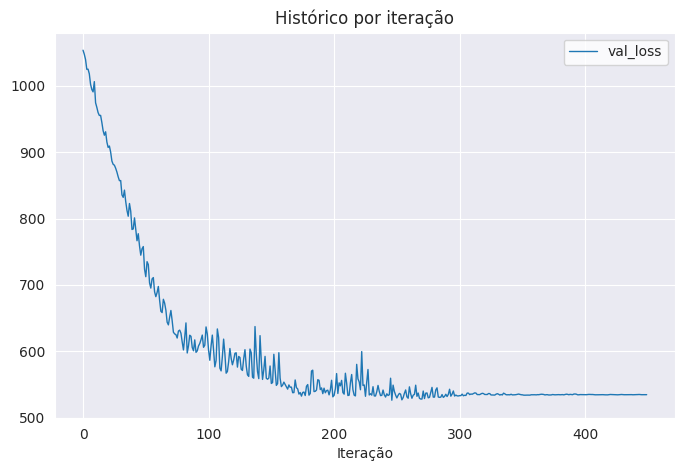

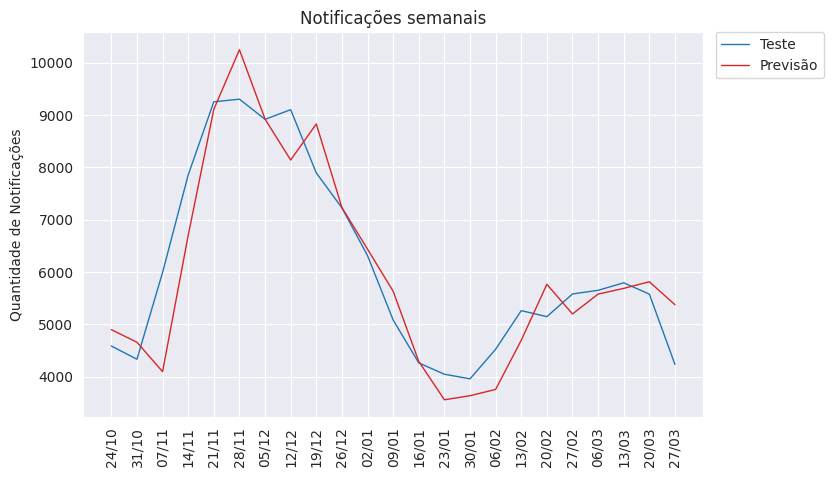


CPU times: user 1min 40s, sys: 2.32 s, total: 1min 43s
Wall time: 1min 44s


In [12]:
%%time

set_global_determinism(seed=SEMENTE)

# for JANELA_TAMANHO in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

janelas, horizontes = criar_janelas(quantidades, JANELA_TAMANHO, HORIZONTE_TAMANHO)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

modelo_nome = f'modelo_{MODELO_NUMERO}_convulacional_{JANELA_TAMANHO}j_{HORIZONTE_TAMANHO}h'

modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

modelos[MODELO_NUMERO].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão aos dados.

modelos[MODELO_NUMERO].add(Conv1D(filters=CAMADA_UNIDADES,
                                  kernel_size=JANELA_TAMANHO,
                                  kernel_initializer=CAMADA_INICIALIZADOR,
                                  padding='causal',
                                  activation=CAMADA_ATIVACAO,
                                  name='camada_convulacional'))

modelos[MODELO_NUMERO].add(Dense(units=HORIZONTE_TAMANHO, activation=SAIDA_ATIVACAO, name='camada_saida'))

finalizacoes = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

historico               = finalizacoes[0]
modelos[MODELO_NUMERO]  = finalizacoes[1]
previsoes               = finalizacoes[2]
metricas[MODELO_NUMERO] = finalizacoes[3]

print(modelo_nome)
print(metricas[MODELO_NUMERO])
print()

grafico_historico_por_iteracao(historico, ['val_loss'], 50)
print()

grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))
print()

MODELO_NUMERO += 1

## Modelos Recorrentes

modelo_4_rnn_simples_6j_1h
{'Mean Absolute Error': 488.58615, 'Root Mean Squared Error': 684.7744, 'Mean Absolute Percentage Error': 0.08335412}



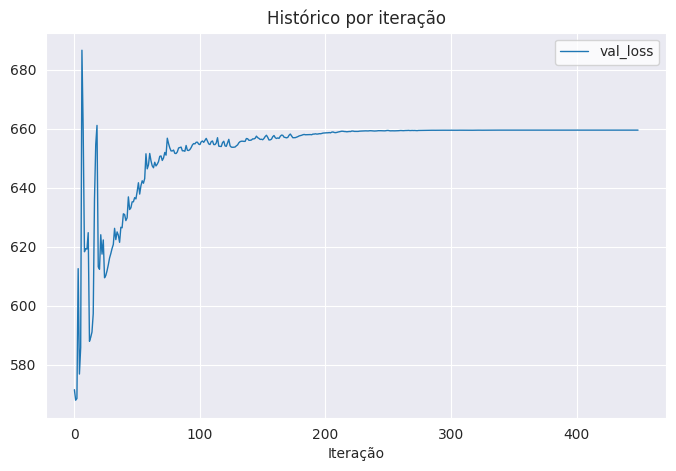

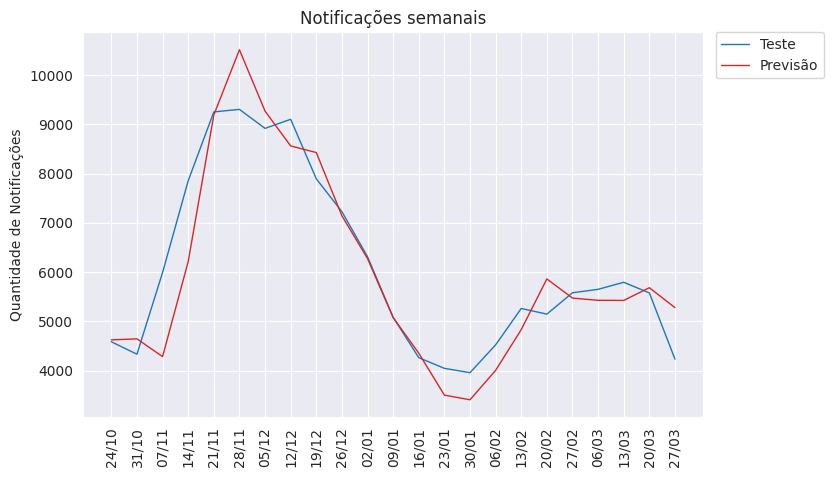


modelo_5_lstm_6j_1h
{'Mean Absolute Error': 673.61365, 'Root Mean Squared Error': 943.3823, 'Mean Absolute Percentage Error': 0.11238787}



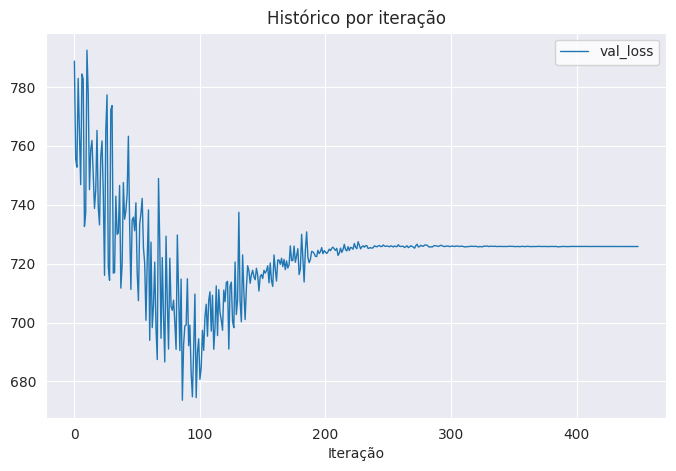

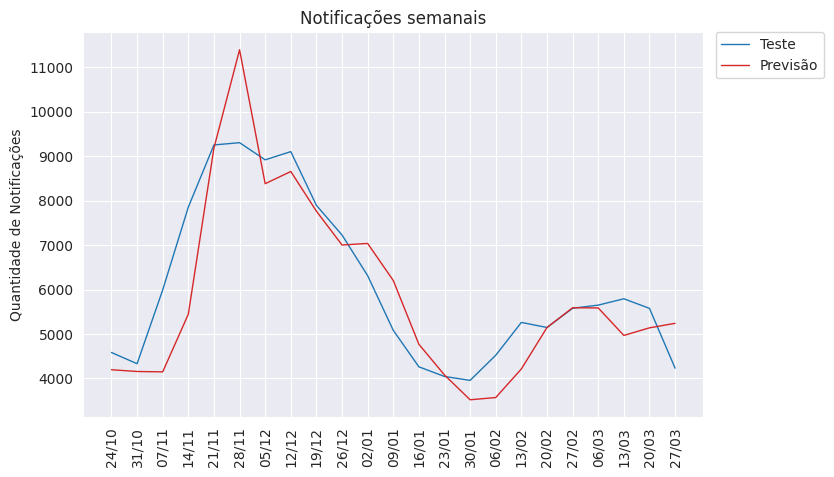


modelo_6_gru_6j_1h
{'Mean Absolute Error': 724.52655, 'Root Mean Squared Error': 942.1084, 'Mean Absolute Percentage Error': 0.118476965}



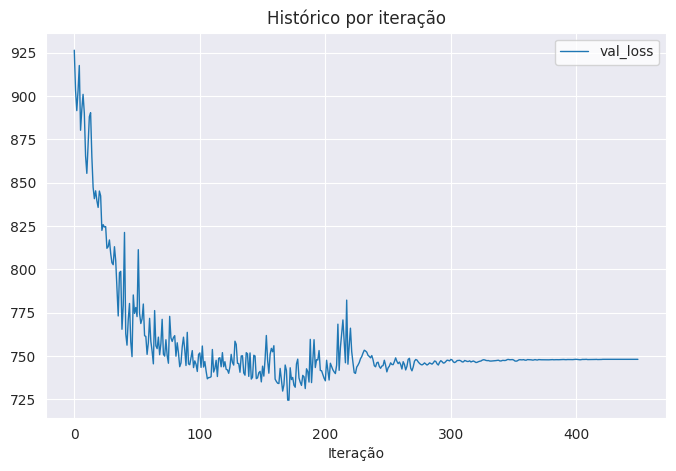

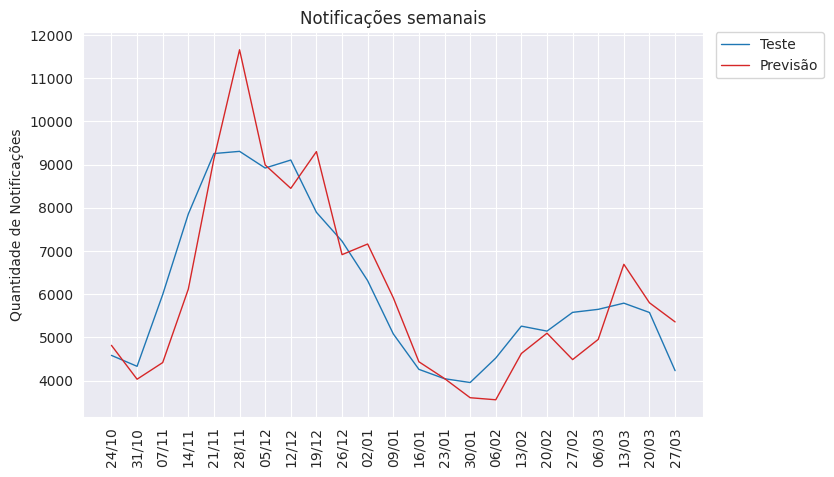


CPU times: user 5min 23s, sys: 7.03 s, total: 5min 30s
Wall time: 7min 14s


In [13]:
%%time

set_global_determinism(seed=SEMENTE)

recorrentes = {'rnn_simples': SimpleRNN, 'lstm': LSTM, 'gru': GRU}

for nome, funcao in recorrentes.items():

    # for JANELA_TAMANHO in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

    janelas, horizontes = criar_janelas(quantidades, JANELA_TAMANHO, HORIZONTE_TAMANHO)

    janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

    modelo_nome = f'modelo_{MODELO_NUMERO}_{nome}_{JANELA_TAMANHO}j_{HORIZONTE_TAMANHO}h'

    modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

    modelos[MODELO_NUMERO].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))

    modelos[MODELO_NUMERO].add(funcao(units=CAMADA_UNIDADES,
                                      kernel_initializer=CAMADA_INICIALIZADOR,
                                      activation=CAMADA_ATIVACAO,  # Ativação 'relu' no lugar de 'tanh' por motivo de performance.
                                      name=f'camada_{nome}'))

    modelos[MODELO_NUMERO].add(Dense(units=CAMADA_UNIDADES, activation=CAMADA_ATIVACAO, name='camada_consolidacao'))
    modelos[MODELO_NUMERO].add(Dense(units=HORIZONTE_TAMANHO, activation=SAIDA_ATIVACAO, name='camada_saida'))
    
    finalizacoes = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

    historico               = finalizacoes[0]
    modelos[MODELO_NUMERO]  = finalizacoes[1]
    previsoes               = finalizacoes[2]
    metricas[MODELO_NUMERO] = finalizacoes[3]

    print(modelo_nome)
    print(metricas[MODELO_NUMERO])
    print()

    grafico_historico_por_iteracao(historico, ['val_loss'], 50)
    print()

    grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
                   X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])
    print()

    MODELO_NUMERO += 1

## Comparação dos modelos

In [14]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])

with pd.option_context('display.max_columns', None):
    display(df_metricas.T)

,0,1,2,3,4,5,6
Mean Absolute Error,641.434783,590.851379,592.069275,526.102051,488.586151,673.613647,724.526550
Root Mean Squared Error,844.882729,803.382751,780.514282,702.336548,684.774414,943.382324,942.108398
Mean Absolute Percentage Error,0.108359,0.097676,0.102521,0.091188,0.083354,0.112388,0.118477


In [15]:
df_metricas['Mean Absolute Error'].sort_values()

4    488.586151
3    526.102051
1    590.851379
2    592.069275
0    641.434783
5    673.613647
6    724.526550
Name: Mean Absolute Error, dtype: float64